In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch
from tqdm.auto import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch import optim
plt.rcParams['font.family'] = 'Malgun Gothic'
# 데이터 불러오기
df_all=pd.read_csv('../data_v3/감성점수와 일별뉴스 합친거.csv',encoding='utf-8')
df = df_all.iloc[:,[1,2,5]]

In [4]:
df_all=pd.read_excel('../data_v3/전국경락단가.xlsx')

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  """Entry point for launching an IPython kernel.


In [5]:
df['경락단가_평균']=df_all['price']
df['경락단가']=df_all['price']
df_all

df.columns=['도매가격_1', '도매가격', 'day_sentiment']

df

,도매가격_1,도매가격,day_sentiment
0,4104,4104,0.000000
1,4049,4049,0.000000
2,3920,3920,-0.104167
3,3917,3917,-0.104167
4,4090,4090,-0.104167
...,...,...,...
620,4718,4718,0.175000
621,4749,4749,-0.116270
622,4820,4820,-0.116270
623,4919,4919,-0.116270


### 도매가격으로 도매가격 예측

In [6]:
CFG={'TRAIN_WINDOW_SIZE':10,
   'PREDICT_SIZE':4 ,
    'how_inputdim':1}

In [7]:
#df=df[['day_sentiment','경락단가_평균']]
df=df[['도매가격_1','도매가격']]

df.tail()

,도매가격_1,도매가격
620,4718,4718
621,4749,4749
622,4820,4820
623,4919,4919
624,4988,4988


In [8]:
# 5일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
batch = 100
CFG={'TRAIN_WINDOW_SIZE':10,
   'PREDICT_SIZE':4 ,
    'how_inputdim':1,
    'data_dim':1,
    'hidden_dim':10,
    'LEARNING_RATE':0.001,
    'nb_epochs':10}

# 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용
train_size = int(len(df)*0.7)
train_set = df[0:train_size]  
test_set = df[train_size-seq_length:]

# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, -1:] = scaler_y.transform(train_set.iloc[:, -1:])
test_set.iloc[:, -1:] = scaler_y.transform(test_set.iloc[:, -1:])

from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 데이터셋 생성 함수
def build_dataset(time_series,train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    dataX = []
    dataY = []
    window_size = train_size + predict_size
    for i in range(len(time_series) - window_size + 1):
        _x = time_series[i:i+train_size, :-1]
        _y = time_series[i+train_size:i+train_size+predict_size, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)




trainX, trainY = build_dataset(np.array(train_set))
testX, testY = build_dataset(np.array(test_set))

NameError: name 'seq_length' is not defined

In [ ]:
# 텐서로 변환
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])
    
    def __len__(self):
        return len(self.X)

In [ ]:
train_dataset = CustomDataset(trainX, trainY)
test_dataset= CustomDataset(testX, testY)

In [ ]:
# 텐서로 변환
'''trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)
testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)'''
'''# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)
val_dataset=TensorDataset(testX_tensor, testY_tensor)'''

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(train_dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)


val_dataloader=DataLoader(test_dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_size, output_size):
        super(Net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_dim, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size//2, output_size)
        )
            
        self.actv = nn.ReLU()
    
    def forward(self, x):
        # x shape: (B, TRAIN_WINDOW_SIZE, 5)
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        
        # LSTM layer
        lstm_out, hidden = self.lstm(x, hidden)
        
        # Only use the last output sequence
        last_output = lstm_out[:, -1, :]
        # Fully connected layer
        output = self.actv(self.fc(last_output))
        return output.squeeze(1)
    
    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))    
    
def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = 9999999
    best_model = None
    
    for epoch in range(1, CFG['nb_epochs']+1):
        model.train()
        train_loss = []
        train_mae = []
        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()
            
            output = model(X)
        
            loss = criterion(output[1], Y[1])
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')
        
        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            print('Model Saved')
    return best_model

def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)
            output = model(X)
            loss = criterion(output[1], Y[1])
            
            val_loss.append(loss.item())
    return np.mean(val_loss)

# 모델 학습
model = Net(CFG['how_inputdim'], CFG['hidden_dim'], CFG['PREDICT_SIZE']).to(device)  
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
infer_model = train(model, optimizer, dataloader, val_dataloader, device)
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
#plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

# # 모델 저장    
# PATH = "./Timeseries_LSTM_data-02-stock_daily_3.pth"
# torch.save(model.state_dict(), PATH)

# # 불러오기
# model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
# model.load_state_dict(torch.load(PATH), strict=False)
# model.eval()

## 모델 테스트

In [9]:
def inference(model, val_dataloader,device):
    model.eval()
    # 예측 테스트
    with torch.no_grad(): 
        pred = []
        for X, Y in tqdm(iter(val_dataloader)):
            X = X.to(device)
            Y = Y.to(device)
            output = model(X)
           
            pred.extend(output)
           
    return output

In [10]:
pred= inference(infer_model, val_dataloader, device)

NameError: name 'infer_model' is not defined

In [11]:
# INVERSE
pred_inverse = scaler_y.inverse_transform(pred.cpu())
testY_inverse = scaler_y.inverse_transform(testY_tensor)

NameError: name 'scaler_y' is not defined

In [12]:
j=0
for i in val_dataloader:
    print(i[1])
    j=j+1

NameError: name 'val_dataloader' is not defined

In [139]:
j

180

pred= inference(infer_model, val_dataloader, device)

def inference(model, val_dataloader, device):
    pred = []
    with torch.no_grad(): 
        for x in tqdm(iter(val_dataloader)):
            print(x[0])
            X = x[0].to(device)   
            output = model(X)
            output = output.cpu().numpy()
            pred.extend(output)
            predicted=np.array(pred)
    return predicted

pred= inference(infer_model, val_dataloader, device)

# INVERSE
pred_inverse = scaler_y.inverse_transform(pred)
testY_inverse = scaler_y.inverse_transform(test_list[1])

In [125]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

#MAE
from sklearn.metrics import mean_absolute_error

print("MAE",mean_absolute_error(testY_inverse,pred_inverse))

#MSE
from sklearn.metrics import mean_squared_error

print("MSE",mean_squared_error(testY_inverse,pred_inverse))

#RMSE
import numpy as np
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(testY_inverse,pred_inverse)
print("MSE",np.sqrt(MSE))
# sklearn 은 mse만 제공하기 때문에 rmse는 직접 만들어 써야한다.

#MAPE
import numpy as np

def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
print("MAPE",MAPE(testY_inverse, pred_inverse))

ValueError: operands could not be broadcast together with shapes (100,4) (188,1) 

In [ ]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("도매가격->도매가격")
plt.legend()
plt.show()

### 도매가격+감성점수-> 도매가격

In [94]:
# 5일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
batch = 100
CFG={'TRAIN_WINDOW_SIZE':10,
   'PREDICT_SIZE':4 ,
    'how_inputdim':1,
    'data_dim':1,
    'hidden_dim':10,
    'learning_rate':0.001,
    'nb_epochs':100}


# 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용
train_size = int(len(df)*0.7)
train_set = df[0:train_size]  
test_set = df[train_size-CFG['TRAIN_WINDOW_SIZE']:]

# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, -1:] = scaler_y.transform(train_set.iloc[:, -1:])
test_set.iloc[:, -1:] = scaler_y.transform(test_set.iloc[:, -1:])

from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 데이터셋 생성 함수
def build_dataset(time_series,train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    dataX = []
    dataY = []
    window_size = train_size + predict_size
    for i in range(len(time_series) - window_size + 1):
        _x = time_series[i:i+train_size, :-1]
        _y = time_series[i+predict_size, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set))
testX, testY = build_dataset(np.array(test_set))

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)
testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)


class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_size=CFG['how_inputdim'],hidden_dim=CFG['hidden_dim'], seq_len=CFG['TRAIN_WINDOW_SIZE'], PREDICT_SIZE=CFG['PREDICT_SIZE'], layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = PREDICT_SIZE
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, PREDICT_SIZE, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        #print("x.shape",x.shape)
        return x

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            x_train=x_train.to(device)
            y_train=y_train.to(device)
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

# 모델 학습
net = Net(data_dim, hidden_dim, seq_length, PREDICT_SIZE, 1).to(device)  
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

# 모델 저장    
PATH = "./Timeseries_LSTM_data-02-stock_daily_.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
model = Net(data_dim, hidden_dim, seq_length, PREDICT_SIZE, 1).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0).to(device) )
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

#MAE
from sklearn.metrics import mean_absolute_error

print("MAE",mean_absolute_error(testY_inverse,pred_inverse))

#MSE
from sklearn.metrics import mean_squared_error

print("MSE",mean_squared_error(testY_inverse,pred_inverse))

#RMSE
import numpy as np
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(testY_inverse,pred_inverse)
print("MSE",np.sqrt(MSE))
# sklearn 은 mse만 제공하기 때문에 rmse는 직접 만들어 써야한다.

#MAPE
import numpy as np

def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
print("MAPE",MAPE(testY_inverse, pred_inverse))

SyntaxError: non-default argument follows default argument (3556978065.py, line 69)

In [ ]:
# 데이터 불러오기
df_all=pd.read_csv('../data_v3/감성점수와 일별뉴스 합친거.csv',encoding='utf-8')
df = df_all.iloc[:,[1,2,5]]

df_all=pd.read_excel('../data_v3/전국경락단가.xlsx')

In [ ]:
def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    '''
    학습 기간 블럭, 예측 기간 블럭의 세트로 데이터를 생성
    data : 일별 판매량
    train_size : 학습에 활용할 기간
    predict_size : 추론할 기간
    '''
    num_rows = len(data)
    window_size = train_size + predict_size
    
    input_data = np.empty((num_rows * (len(data.columns) - window_size + 1), train_size, len(data.iloc[0, :CFG['how_inputdim']]) + 1))
    target_data = np.empty((num_rows * (len(data.columns) - window_size + 1), predict_size))
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :CFG['how_inputdim']])
        sales_data = np.array(data.iloc[i, CFG['how_inputdim']:])
        
        for j in range(len(sales_data) - window_size + 1):
            window = sales_data[j : j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            input_data[i * (len(data.columns) - window_size + 1) + j] = temp_data
            target_data[i * (len(data.columns) - window_size + 1) + j] = window[train_size:]
    
    return input_data, target_data

In [ ]:
train_input, train_target = make_train_data(df)

In [ ]:
df['경락단가_평균']=df_all['price']
df['경락단가']=df_all['price']
df_all

df.columns=['도매가격_1', '도매가격', 'day_sentiment']

df

In [ ]:
CFG['how_inputdim']

In [ ]:
#df=df[['day_sentiment','경락단가_평균']]
df=df[['day_sentiment','도매가격']]


# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 5
batch = 100

# 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용
train_size = int(len(df)*0.7)
train_set = df[0:train_size]  
test_set = df[train_size-seq_length:]

# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, -1:] = scaler_y.transform(train_set.iloc[:, -1:])
test_set.iloc[:, -1:] = scaler_y.transform(test_set.iloc[:, -1:])

from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)
testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

In [ ]:
# Train / Validation Split
data_len = len(train_input)
val_input = train_input[-int(data_len*0.2):]
val_target = train_target[-int(data_len*0.2):]
train_input = train_input[:-int(data_len*0.2)]
train_target = train_target[:-int(data_len*0.2)]

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])
    
    def __len__(self):
        return len(self.X)

In [ ]:
train_dataset = CustomDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
for j in dataset:
    print(j)

In [ ]:
# 설정값
data_dim = 2
hidden_dim = 10 
output_dim = 1
learning_rate = 0.01
nb_epochs = 100
class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            x_train=x_train.to(device)
            y_train=y_train.to(device)
            #print("x_train",x_train)
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

# 모델 학습
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

# 모델 저장    
PATH = "./Timeseries_LSTM_data-02-stock_daily_3.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0).to(device) )
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor)

In [ ]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

#MAE
from sklearn.metrics import mean_absolute_error

print("MAE",mean_absolute_error(testY_inverse,pred_inverse))

#MSE
from sklearn.metrics import mean_squared_error

print("MSE",mean_squared_error(testY_inverse,pred_inverse))

#RMSE
import numpy as np
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(testY_inverse,pred_inverse)
print("MSE",np.sqrt(MSE))
# sklearn 은 mse만 제공하기 때문에 rmse는 직접 만들어 써야한다.

#MAPE
import numpy as np

def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
print("MAPE",MAPE(testY_inverse, pred_inverse))

In [ ]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("도매가격+감성점수->도매가격")
plt.legend()
plt.show()

# 경락단가->도매가격

In [95]:
#df=df[['day_sentiment','경락단가_평균']]
df=df[['경락단가','도매가격']]


# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 5
batch = 100

# 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용
train_size = int(len(df)*0.7)
train_set = df[0:train_size]  
test_set = df[train_size-seq_length:]

# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, -1:] = scaler_y.transform(train_set.iloc[:, -1:])
test_set.iloc[:, -1:] = scaler_y.transform(test_set.iloc[:, -1:])

from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)
testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

# 설정값
data_dim = 1
hidden_dim = 10 
output_dim = 1
learning_rate = 0.01
nb_epochs = 100
class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            x_train=x_train.to(device)
            y_train=y_train.to(device)
            #print("x_train",x_train)
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

# 모델 학습
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

# 모델 저장    
PATH = "./Timeseries_LSTM_data-02-stock_daily_2.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0).to(device) )
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor)

KeyError: "['경락단가'] not in index"

In [ ]:
# 데이터 불러오기
df_all=pd.read_csv('../data_v3/감성점수와 일별뉴스 합친거.csv',encoding='utf-8')
df = df_all.iloc[:,[1,2,5]]

df_all=pd.read_excel('../data_v3/전국경락단가.xlsx')

In [ ]:
df['경락단가_평균']=df_all['price']

df_all

df.columns=['경락단가', '도매가격', 'day_sentiment']

df

### 모델링

In [ ]:
#df=df[['day_sentiment','경락단가_평균']]
df=df[['경락단가','도매가격']]


# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 5
batch = 100

# 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용
train_size = int(len(df)*0.7)
train_set = df[0:train_size]  
test_set = df[train_size-seq_length:]

# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, -1:] = scaler_y.transform(train_set.iloc[:, -1:])
test_set.iloc[:, -1:] = scaler_y.transform(test_set.iloc[:, -1:])

from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :-1]
        _y = time_series[i+seq_length, [-1]]
    
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)
testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)
val_dataset=TensorDataset(testX_tensor, testY_tensor)
# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)


val_dataloader=DataLoader(val_dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

# 설정값
data_dim = 1
hidden_dim = 10 
output_dim = 1
learning_rate = 0.01
nb_epochs = 100
class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            x_train=x_train.to(device)
            y_train=y_train.to(device)
            #print("x_train",x_train)
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

# 모델 학습
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

# 모델 저장    
PATH = "./Timeseries_LSTM_data-02-stock_daily_2.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0).to(device) )
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor)

In [ ]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

#MAE
from sklearn.metrics import mean_absolute_error

print("MAE",mean_absolute_error(testY_inverse,pred_inverse))

#MSE
from sklearn.metrics import mean_squared_error

print("MSE",mean_squared_error(testY_inverse,pred_inverse))

#RMSE
import numpy as np
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(testY_inverse,pred_inverse)
print("MSE",np.sqrt(MSE))
# sklearn 은 mse만 제공하기 때문에 rmse는 직접 만들어 써야한다.

#MAPE
import numpy as np

def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
print("MAPE",MAPE(testY_inverse, pred_inverse))

In [ ]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("경락단가->도매가격")
plt.legend()
plt.show()

# 경락단가+감성점수->도매가격

In [96]:
# 데이터 불러오기
df_all=pd.read_csv('../data_v3/감성점수와 일별뉴스 합친거.csv',encoding='utf-8')
df = df_all.iloc[:,[1,2,5]]

df_all=pd.read_excel('../data_v3/전국경락단가.xlsx')

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  """


In [97]:
df['경락단가_평균']=df_all['price']

df_all

df.columns=['경락단가', '도매가격', 'day_sentiment']

df

,경락단가,도매가격,day_sentiment
0,3750.366093,4104,0.000000
1,3547.574932,4049,0.000000
2,3696.060897,3920,-0.104167
3,3770.156364,3917,-0.104167
4,3809.974684,4090,-0.104167
...,...,...,...
620,4547.071429,4718,0.175000
621,4373.212544,4749,-0.116270
622,4278.649485,4820,-0.116270
623,4322.080986,4919,-0.116270


### 모델링

In [ ]:
#df=df[['day_sentiment','경락단가_평균']]
df=df[['경락단가','day_sentiment','도매가격']]


# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 5
batch = 100

# 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용
train_size = int(len(df)*0.7)
train_set = df[0:train_size]  
test_set = df[train_size-seq_length:]

# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, -1:] = scaler_y.transform(train_set.iloc[:, -1:])
test_set.iloc[:, -1:] = scaler_y.transform(test_set.iloc[:, -1:])

from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :-1]
        _y = time_series[i+seq_length, [-1]]
    
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)
testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

# 설정값
data_dim = 2
hidden_dim = 10 
output_dim = 1
learning_rate = 0.01
nb_epochs = 100
class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            x_train=x_train.to(device)
            y_train=y_train.to(device)
            #print("x_train",x_train)
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

# 모델 학습
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

# 모델 저장    
PATH = "./Timeseries_LSTM_data-02-stock_daily_2.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

In [99]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

#MAE
from sklearn.metrics import mean_absolute_error

print("MAE",mean_absolute_error(testY_inverse,pred_inverse))

#MSE
from sklearn.metrics import mean_squared_error

print("MSE",mean_squared_error(testY_inverse,pred_inverse))

#RMSE
import numpy as np
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(testY_inverse,pred_inverse)
print("MSE",np.sqrt(MSE))
# sklearn 은 mse만 제공하기 때문에 rmse는 직접 만들어 써야한다.

#MAPE
import numpy as np

def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
print("MAPE",MAPE(testY_inverse, pred_inverse))

MAE SCORE :  778.9570416967734
MAE 778.9570416967734
MSE 890356.1775922187
MSE 943.5868680689758
MAPE 22.19071253736312


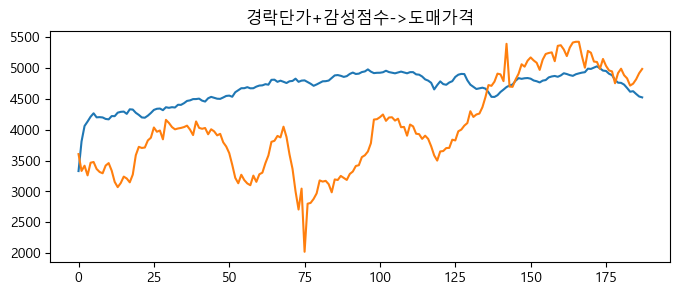

In [100]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("경락단가+감성점수->도매가격")
plt.show()